In [1]:
!pip install rectools hnswlib optuna annoy > None

In [2]:
import os

import pandas as pd
import numpy as np
from scipy import sparse

import requests
from tqdm.auto import tqdm

from rectools.dataset import Dataset
from rectools.models.implicit_als import ImplicitALSWrapperModel
from rectools.metrics import MAP
from rectools import Columns
from lightfm import LightFM

import implicit
from implicit.als import AlternatingLeastSquares

import optuna
import hnswlib
from annoy import AnnoyIndex

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd gdrive/MyDrive/recsys/

/content/gdrive/MyDrive/recsys


In [6]:
SEED = 2022
K_RECOS = 10

## Get data

In [7]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,user_id,item_id
0,3,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
1,11,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
2,29,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
3,30,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
4,33,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."


In [8]:
def load_data():
  interactions = pd.read_csv('kion_train/interactions.csv')
  users = pd.read_csv('kion_train/users.csv')
  items = pd.read_csv('kion_train/items.csv')
  interactions.rename(
    columns={
        'last_watch_dt': 'datetime',
        'total_dur': 'weight',
    },
    inplace=True,
  )

  interactions['datetime'] = pd.to_datetime(interactions['datetime'])
  interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
  return interactions, users, items

In [9]:
interactions, users, items = load_data()
last_date = interactions['datetime'].max().normalize()

train = interactions[interactions[Columns.Datetime] < last_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= last_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 5)
test: (490982, 5)


In [10]:
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [11]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

In [12]:
TEST_USERS = test[Columns.User].unique()

## Prepare user features

In [13]:
users.fillna('Unknown', inplace=True)

In [14]:
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
5,1037719,age_45_54,income_60_90,М,0


In [15]:
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex


## Prepare item features

In [16]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [17]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [18]:
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [19]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature.head()

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


In [20]:
items['binned_r_year'] = pd.qcut(items['release_year'], q=10, labels=list(range(10)))
release_year_feature = items.reindex(columns=[Columns.Item, "binned_r_year"])
release_year_feature.columns = ["id", "value"]
release_year_feature["feature"] = "binned_r_year"
release_year_feature.head()

,id,value,feature
0,10711,1,binned_r_year
1,2508,4,binned_r_year
2,10716,3,binned_r_year
3,7868,5,binned_r_year
4,16268,0,binned_r_year


In [21]:
items["country"] = items["countries"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
country_feature = items[["item_id", "country"]].explode("country")
country_feature.columns = ["id", "value"]
country_feature["feature"] = "country"
country_feature.head()

,id,value,feature
0,10711,испания,country
1,2508,сша,country
2,10716,канада,country
3,7868,великобритания,country
4,16268,ссср,country


In [22]:
item_features = pd.concat((genre_feature, content_feature, country_feature, release_year_feature))
item_features[item_features['id'] == 10711]

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
0,10711,film,content_type
0,10711,испания,country
0,10711,1,binned_r_year


## Init dataset

In [23]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "country", 'binned_r_year', 'content_type'],
)

## Models

In [24]:
def calc_map(reco):
    global test, TEST_USERS, K_RECOS
    if type(reco) != pd.core.frame.DataFrame:
      reco_df = pd.DataFrame(
          {
              Columns.User: np.repeat(TEST_USERS, K_RECOS),
              Columns.Item: np.array(reco).ravel(),
              Columns.Rank: np.tile(np.arange(K_RECOS) + 1, len(TEST_USERS)),
          }
      )
      metric = MAP(k=K_RECOS).calc(reco_df, test)
    else:
      metric = MAP(k=K_RECOS).calc(reco, test)
    return metric

### ALS from HW 2

In [25]:
model_obj = ImplicitALSWrapperModel(
      model=AlternatingLeastSquares(
        factors=128, 
        regularization=0.21,
        random_state=SEED, 
      ),
      fit_features_together=True,
    )

model_obj.fit(dataset)

### ANN

In [26]:
def get_mapping(train_df, col):
  inv_mapping = dict(enumerate(train_df[col].unique()))
  mapping = {v: k for k, v in inv_mapping.items()}
  return inv_mapping, mapping

In [27]:
users_inv_mapping, users_mapping = get_mapping(train, 'user_id')
items_inv_mapping, items_mapping = get_mapping(train, 'item_id')

In [28]:
users_factors = model_obj.model.user_factors
items_factors = model_obj.model.item_factors

In [ ]:
%%time
ann_index = hnswlib.Index(space="ip", dim=model_obj.model.factors)
ann_index.init_index(max_elements=items_factors.shape[0])

CPU times: user 1.12 ms, sys: 9 µs, total: 1.13 ms
Wall time: 1.57 ms


In [ ]:
%%time
ann_index.add_items(items_factors)

CPU times: user 5.44 s, sys: 19.5 ms, total: 5.46 s
Wall time: 2.88 s


In [ ]:
TEST_USERS_INNER_IDS = [users_mapping[user_id] for user_id in TEST_USERS]

In [ ]:
%%time
test_user_factors = users_factors[TEST_USERS_INNER_IDS]
reco_ann, _ = ann_index.knn_query(test_user_factors, K_RECOS)

CPU times: user 5.69 s, sys: 7.99 ms, total: 5.7 s
Wall time: 3.4 s


In [ ]:
reco_ann = np.array([np.array([items_inv_mapping[item_id] for item_id in reco]) for reco in reco_ann])

In [ ]:
calc_map(reco_ann)

0.058515543882168966

#### Filter viewed

In [ ]:
%%time
test_user_factors = users_factors[TEST_USERS_INNER_IDS]
reco_ann, _ = ann_index.knn_query(test_user_factors, K_RECOS + 60)

CPU times: user 26.4 s, sys: 41.6 ms, total: 26.4 s
Wall time: 14.7 s


In [ ]:
reco_ann = np.array([np.array([items_inv_mapping[item_id] for item_id in reco]) for reco in reco_ann])

In [ ]:
def filter_viewed(recos):
  if type(recos) != list:
    recos = map(lambda x: x.tolist(), recos)

  test_recs = pd.DataFrame(TEST_USERS.reshape(-1, 1), columns=['user_id'])
  test_recs['item_id'] = pd.Series(recos)
  test_recs = test_recs.explode('item_id')

  viewed_items = train[train['user_id'].isin(TEST_USERS)]
  viewed_recs = test_recs.merge(viewed_items[['user_id', 'item_id']], on=['user_id', 'item_id'], how='left', indicator=True)
  new_recs = viewed_recs[viewed_recs['_merge'] != 'both']

  new_recs['rank'] = new_recs.groupby('user_id').cumcount() + 1
  new_recs = new_recs[new_recs['rank'] < 11]
  new_recs = new_recs.drop('_merge', axis=1)
  return new_recs

In [ ]:
new_recs = filter_viewed(reco_ann)
new_recs.shape

(1205190, 3)

In [ ]:
assert new_recs.groupby('user_id').count().min()['rank'] == 10

In [ ]:
calc_map(new_recs)

0.07891760605247324

Metric is better than previous

#### Tuning ANN index params

In [ ]:
def print_study_info(study):
  print("Number of finished trials: ", len(study.trials))
  print("Params: ")
  for key, value in study.best_trial.params.items():
      print("    {}: {}".format(key, value))

In [ ]:
def objective_ANNModel(trial):
    M = trial.suggest_int("M", low=16, high=96, step=8)
    ef_construction = trial.suggest_int("ef_construction", low=180, high=280, step=20)

    ann_index = hnswlib.Index(space="ip", dim=model_obj.model.factors)
    ann_index.init_index(max_elements=items_factors.shape[0], M=M, ef_construction=ef_construction)
    ann_index.add_items(items_factors)
    test_user_factors = users_factors[TEST_USERS_INNER_IDS]
    reco_ann, _ = ann_index.knn_query(test_user_factors, K_RECOS + 60)
    reco_ann = np.array([np.array([items_inv_mapping[item_id] for item_id in reco]) for reco in reco_ann])

    new_recs = filter_viewed(reco_ann)
    metric = calc_map(new_recs)

    return metric

In [ ]:
%%time

study = optuna.create_study(direction="maximize")
study.optimize(objective_ANNModel, n_trials=30)

[I 2022-12-11 15:36:35,132] A new study created in memory with name: no-name-836c8aea-3539-4a13-848f-67225c347960
[I 2022-12-11 15:37:22,299] Trial 0 finished with value: 0.07969500003571876 and parameters: {'M': 56, 'ef_construction': 240}. Best is trial 0 with value: 0.07969500003571876.
[I 2022-12-11 15:38:11,882] Trial 1 finished with value: 0.07968010449367492 and parameters: {'M': 56, 'ef_construction': 200}. Best is trial 0 with value: 0.07969500003571876.
[I 2022-12-11 15:38:59,388] Trial 2 finished with value: 0.07970867943497817 and parameters: {'M': 48, 'ef_construction': 240}. Best is trial 2 with value: 0.07970867943497817.
[I 2022-12-11 15:39:43,908] Trial 3 finished with value: 0.0792486516614019 and parameters: {'M': 24, 'ef_construction': 260}. Best is trial 2 with value: 0.07970867943497817.
[I 2022-12-11 15:40:32,884] Trial 4 finished with value: 0.07970299837521762 and parameters: {'M': 80, 'ef_construction': 280}. Best is trial 2 with value: 0.07970867943497817.
[I

CPU times: user 33min 44s, sys: 13 s, total: 33min 57s
Wall time: 24min 4s


In [ ]:
print_study_info(study)

Number of finished trials:  30
Params: 
    M: 72
    ef_construction: 200


In [ ]:
study.best_value

0.0797214154703177

#### Annoy

In [ ]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()
    
    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [ ]:
users_factors.shape, items_factors.shape

((896791, 352), (15565, 352))

In [ ]:
max_norm, augmented_item_factors = augment_inner_product(items_factors)
augmented_item_factors.shape

(15565, 353)

In [ ]:
extra_zero = np.zeros((users_factors.shape[0], 1))
augmented_user_factors = np.append(users_factors, extra_zero, axis=1)
augmented_user_factors.shape

(896791, 353)

In [ ]:
def objective_ANN_Annoy_Model(trial):
    n_trees = trial.suggest_int("M", low=60, high=160, step=20)

    index = AnnoyIndex(augmented_item_factors.shape[1], 'dot')
    for i in range(len(augmented_item_factors)):
        index.add_item(i, augmented_item_factors[i])
    index.build(n_trees=n_trees)

    nbrs = [index.get_nns_by_vector(query_matrix[i], 60) for i in range(len(query_matrix))]
    reco_ann = np.array([np.array([items_inv_mapping[item_id] for item_id in reco]) for reco in nbrs])
    new_recs = filter_viewed(reco_ann)
    metric = calc_map(new_recs)

    return metric

In [ ]:
query_matrix = augmented_user_factors[TEST_USERS_INNER_IDS]

In [ ]:
%%time

study = optuna.create_study(direction="maximize")
study.optimize(objective_ANN_Annoy_Model, n_trials=10)

[I 2022-12-11 16:08:34,287] A new study created in memory with name: no-name-6fcb0403-fa43-4eda-b3b3-95a14fd162b6
[I 2022-12-11 16:10:38,505] Trial 0 finished with value: 0.061505256519803715 and parameters: {'M': 120}. Best is trial 0 with value: 0.061505256519803715.
[I 2022-12-11 16:11:53,931] Trial 1 finished with value: 0.046737089485880096 and parameters: {'M': 60}. Best is trial 0 with value: 0.061505256519803715.
[I 2022-12-11 16:13:04,702] Trial 2 finished with value: 0.046737089485880096 and parameters: {'M': 60}. Best is trial 0 with value: 0.061505256519803715.
[I 2022-12-11 16:15:20,775] Trial 3 finished with value: 0.06436387383909478 and parameters: {'M': 140}. Best is trial 3 with value: 0.06436387383909478.
[I 2022-12-11 16:16:50,967] Trial 4 finished with value: 0.05269613371291527 and parameters: {'M': 80}. Best is trial 3 with value: 0.06436387383909478.
[I 2022-12-11 16:18:36,091] Trial 5 finished with value: 0.05881851178179901 and parameters: {'M': 100}. Best is 

CPU times: user 18min 47s, sys: 5.99 s, total: 18min 53s
Wall time: 18min 35s


In [ ]:
print_study_info(study)

Number of finished trials:  10
Params: 
    M: 160


In [ ]:
study.best_value

0.06583661886295324

#### Best model

The best model is hnswlib

In [30]:
def filter_viewed(recos, test_users):
  if type(recos) != list:
    recos = map(lambda x: x.tolist(), recos)

  test_recs = pd.DataFrame(test_users.reshape(-1, 1), columns=['user_id'])
  test_recs['item_id'] = pd.Series(recos)
  test_recs = test_recs.explode('item_id')

  viewed_items = train[train['user_id'].isin(test_users)]
  viewed_recs = test_recs.merge(viewed_items[['user_id', 'item_id']], on=['user_id', 'item_id'], how='left', indicator=True)
  new_recs = viewed_recs[viewed_recs['_merge'] != 'both']

  new_recs['rank'] = new_recs.groupby('user_id').cumcount() + 1
  new_recs = new_recs[new_recs['rank'] < 11]
  new_recs = new_recs.drop('_merge', axis=1)
  return new_recs

In [29]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold = recs[~recs['user_id'].isin(train.user_id)]
warm = recs[recs['user_id'].isin(train.user_id)]

In [46]:
ann_index = hnswlib.Index(space="ip", dim=model_obj.model.factors)
ann_index.init_index(max_elements=items_factors.shape[0], M=72, ef_construction=200)
ann_index.add_items(items_factors)

TEST_USERS_INNER_IDS = np.array([users_mapping[user_id] for user_id in warm['user_id'].unique()])
test_user_factors = users_factors[TEST_USERS]
reco_ann, _ = ann_index.knn_query(test_user_factors, K_RECOS + 60)
reco_ann = np.array([np.array([items_inv_mapping[item_id] for item_id in reco]) for reco in reco_ann])
new_recs = filter_viewed(reco_ann, warm['user_id'].unique())

### Submit

In [32]:
cold_recs = [[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734] for i in range(len(cold['user_id']))]
cold_recs = pd.DataFrame(list(zip(cold['user_id'].values.tolist(), cold_recs)), columns=['user_id', 'item_id'])
cold_recs.head()

,user_id,item_id
0,29,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
1,33,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
2,39,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
3,70,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."
4,74,"[9728, 10440, 15297, 13865, 14488, 12192, 1236..."


In [47]:
recos = new_recs.drop(['rank'], axis=1).groupby('user_id').agg({'item_id': list}).reset_index()
recos.head()

,user_id,item_id
0,3,"[15297, 13865, 9996, 8636, 6809, 4740, 4495, 7..."
1,11,"[10440, 13865, 9728, 4151, 142, 3734, 2657, 99..."
2,30,"[15297, 10440, 4151, 13865, 2657, 3734, 142, 9..."
3,46,"[15297, 9728, 4151, 13865, 3734, 2657, 6809, 9..."
4,47,"[9728, 10440, 15297, 4151, 3734, 8636, 11237, ..."


In [48]:
res = pd.concat((cold_recs, recos))
res.shape

(193113, 2)

In [50]:
res = pd.concat((cold_recs, recos))
assert res.shape[0] == submission.shape[0]
res.to_csv('ann.csv', index=False)

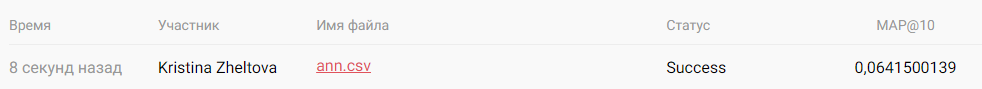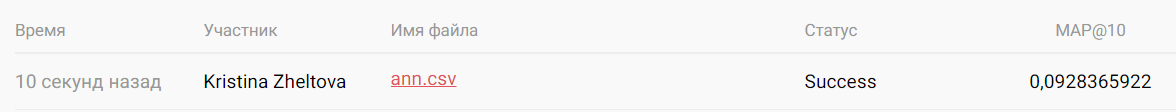